In [37]:
from typing import List, Tuple
from functools import lru_cache

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import os
import wandb

In [38]:
api = wandb.Api()

In [39]:
sns.set(font_scale=1.5)
sns.set_style('whitegrid')
sns.set_palette('deep')

In [40]:
keys = [
    "eval/mean_episode_agent_score", 
    "eval/mean_episode_agent_turns", 
    "eval/mean_episode_eating_score", 
    "eval/mean_episode_gold_score", 
    "eval/mean_episode_scout_score", 
    "eval/mean_episode_staircase_score", 
    "eval/mean_episode_staircasepet_score", 
    "eval/mean_episode_dlvl", 
    "eval/mean_episode_experience_level", 
    "eval/mean_episode_experience_points", 
    "eval/mean_episode_max_hitpoints", 
    "eval/mean_episode_max_energy", 
    "eval/mean_episode_armor_class", 
    "eval/mean_episode_sokobanfillpit_score", 
    "eval/mean_episode_sokobansolvedlevel_score", 
    "global/env_train_steps",
]

In [41]:
filters = {"config.exp_tags": ["2023_09_22_eval_full"], "config.exp_kind": "eval_stitch"}

In [42]:
runs = api.runs("gmum/nle", filters=filters)
data = []
for run in runs:
    try:
        df = run.history(samples=30000, keys=keys)
        df = pd.DataFrame(df)
        df["seed"] = run.config["seed"]
        df["name"] = run.config["name"]
        df["group"] = run.config["group"]
        df["exp_point"] = run.config["exp_point"]
        data.append(df)
    except Exception as e:
        pass

data = pd.concat(data, axis=0).reset_index()

In [43]:
data.to_csv("raw.csv")

In [14]:
# data = pd.read_csv("raw.csv")

In [91]:
# data

In [45]:
data["index"] = data["_step"] - data["_step"] % 10_000_000

In [52]:
first_step_appo = data[data["group"].str.contains("APPO_") & (data["index"] == 100000000)].copy()
first_step_appo.loc[:, keys] = 0
first_step_appo.loc[:, "index"] = 0
data = pd.concat([data, first_step_appo])

In [110]:
methods = [
    "monk-APPO_",
    "monk-APPO-T",
    "monk-APPO-AA-KLAA-T",
    "monk-APPO-EWC-T",
    # "monk-APPO-AA-KL-T",
    # "monk-APPO-AA-KS-T",
    # "monk-APPO-AA-BC-T",
]

method_names = [
    "monk-APPO",
    "monk-APPO-T",
    "monk-APPO-AA-KLAA-T",
    "monk-APPO-EWC-T",
    # "monk-APPO-AA-KLBC-T",
    # "monk-APPO-AA-KS-T",
    # "monk-APPO-AA-CEAA-T",
]

folders = []
folders.append("None")
for i in range(2, 10):
    folder = f"saves{i}"
    folders.append(folder)
folders.append("sokoban")

In [86]:
color_palette = sns.color_palette("Set1", 7)

In [140]:
n_rows = 3
n_cols = 5

method_translator = {
    "monk-APPO": "APPO",
    "monk-APPO-T": "APPO-FT",
    "monk-APPO-AA-KLAA-T": "APPO-BC",
    # "monk-APPO-AA-KLBC-T",
    "monk-APPO-AA-KS-T": "APPO-KS",
    "monk-APPO-AA-CEAA-T": "APPO-CE",
    "monk-APPO-EWC-T": "APPO-EWC",
}

for level in folders:
    level_data = data[data["name"].str.contains(level)]

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(32, 14))

    axes = axes.flatten()
    legend_handles = []  # Create an empty list to collect legend handles
    legend_labels = []   # Create an empty list to collect legend labels


    for idx, (ax, eval_column) in enumerate(zip(axes, keys[:13])):
        for e, (method, method_name) in enumerate(zip(methods, method_names)):
            if method_name == "monk-APPO":
                continue
            method_data = level_data[level_data["group"].str.contains(method)]

            method_data = method_data.replace('NaN', pd.NA).dropna()

            legend = "full" if idx == 0 else None
            sns.lineplot(data=method_data, x="index", y=eval_column, ax=ax, errorbar=('ci', 90), linewidth=3, legend=legend, label=method_translator[method_name], color=color_palette[e])
            
            ax.set_ylabel("")
            ax.set_xlabel("# env steps")
            ax.set_xlim(0, 2_000_000_000)
            
            ax_title = eval_column[5:]
            ax_title = " ".join(ax_title.split("_"))
            ax.set_title(f"{ax_title}")
        # if idx == 1:
        #     break

    plt.tight_layout()

    for ax in axes[13:]:
        ax.axis('off')

    plot_title = level if level != "None" else "start"
    plot_title = f"level {plot_title[-1]}" if "saves" in plot_title else plot_title
    plot_title = f"Play from {plot_title}"
    fig.suptitle(plot_title, fontsize=22)
    fig.subplots_adjust(top=0.91)
    # plt.show()
    plt.savefig(f"{level}.png")

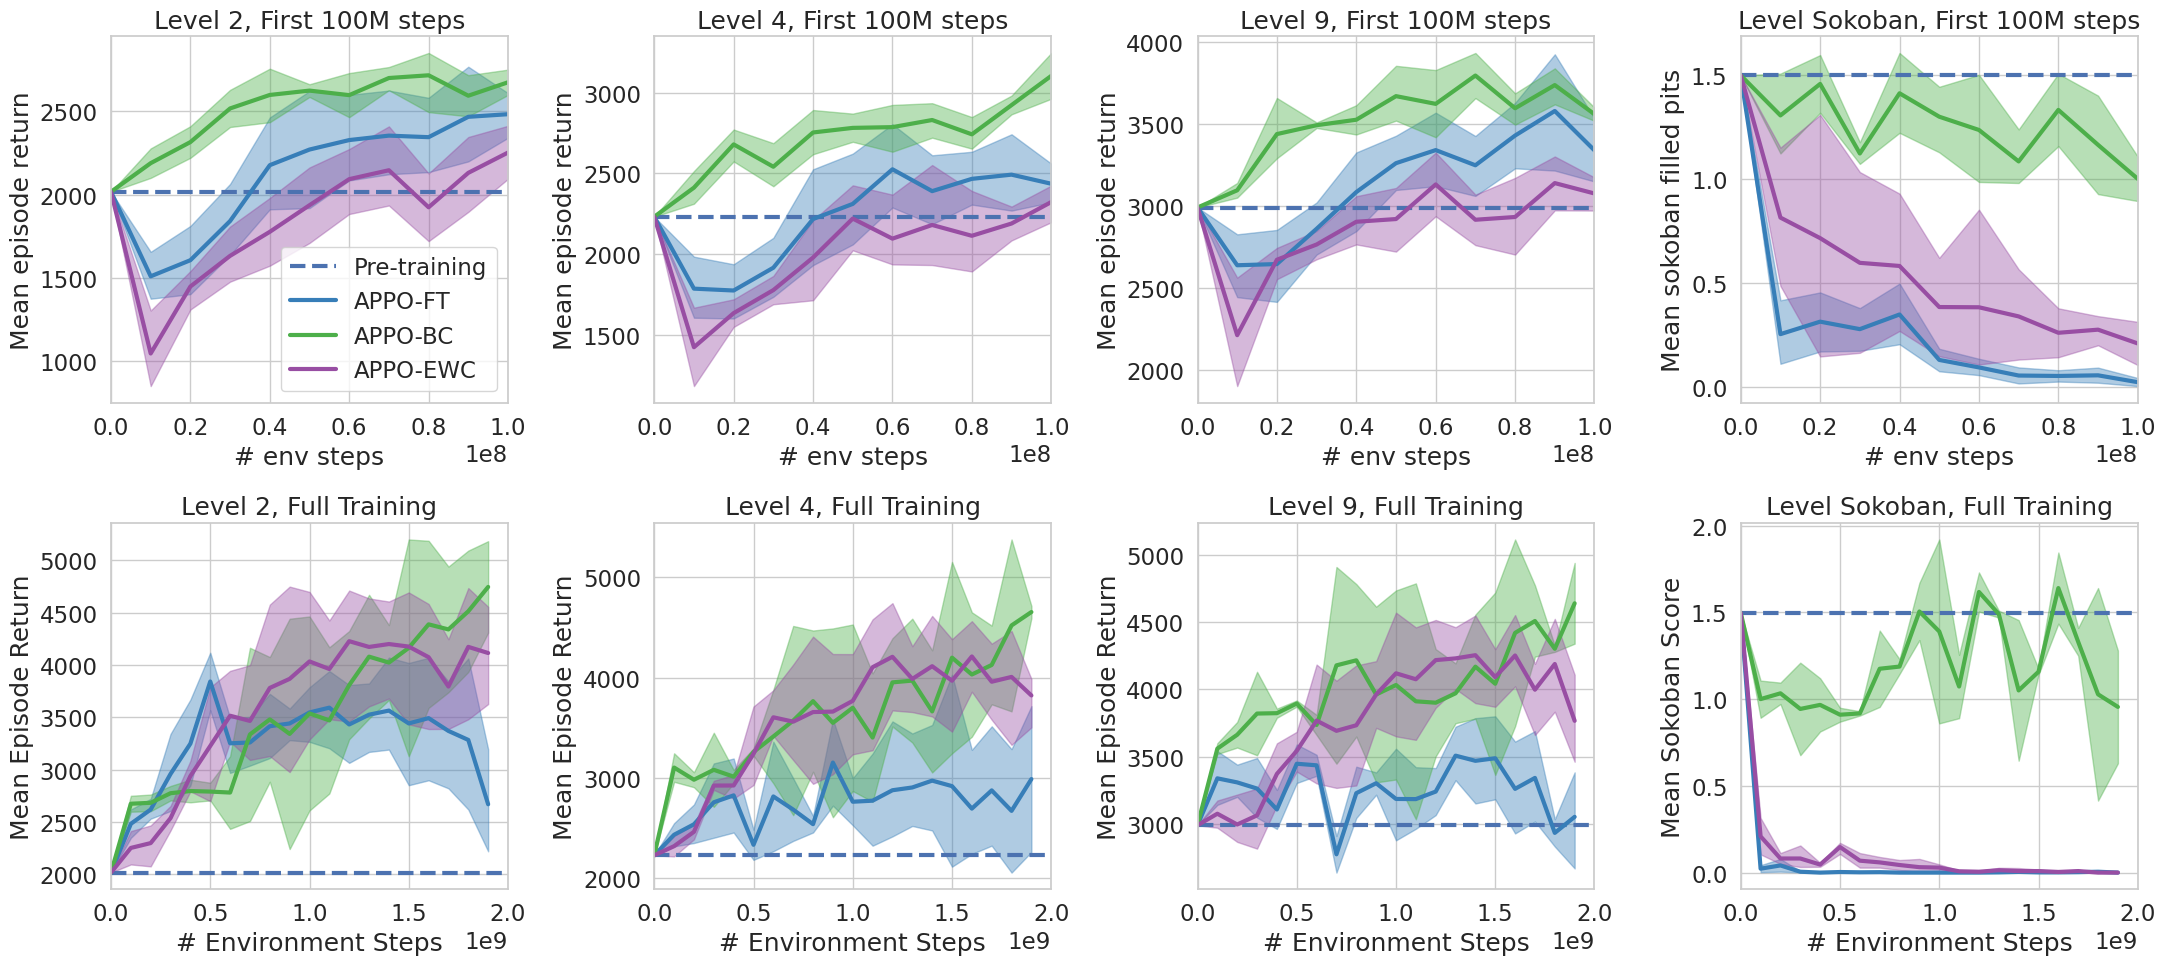

In [139]:
n_rows = 2
n_cols = 4

fig, axes = plt.subplots(n_rows, n_cols, figsize=(22, 10))

axes = axes.flatten()
legend_handles = []  # Create an empty list to collect legend handles
legend_labels = []   # Create an empty list to collect legend labels

folders = ["saves2", "saves4", "saves9", "sokoban"]

method_translator = {
    "monk-APPO": "APPO",
    "monk-APPO-T": "APPO-FT",
    "monk-APPO-AA-KLAA-T": "APPO-BC",
    # "monk-APPO-AA-KLBC-T",
    "monk-APPO-AA-KS-T": "APPO-KS",
    "monk-APPO-AA-CEAA-T": "APPO-CE",
    "monk-APPO-EWC-T": "APPO-EWC",
}

# TODO: all points should have the same 0-point

# [0 - 100M]
for idx, (ax, level) in enumerate(zip(axes, folders)):
    eval_column = "eval/mean_episode_sokobanfillpit_score" if level == "sokoban" else 'eval/mean_episode_agent_score'
    level_data = data[data["name"].str.contains(level)]
    baseline_val = level_data[(level_data['index'] == 0) & (level_data['group'].str.contains('-T'))][eval_column].mean()
    ax.plot([0, 100_000_000], [baseline_val, baseline_val], linestyle='--', label="Pre-training", linewidth=3)
    for e, (method, method_name) in enumerate(zip(methods, method_names)):
        if "BC" in method_name or method_name == "monk-APPO":
            continue
        method_data = level_data[level_data["group"].str.contains(method)].copy()

        method_data = method_data.replace('NaN', pd.NA).dropna()
        method_data = method_data[method_data['index'] <= 100_000_000]
        method_data.loc[method_data['index'] == 0, eval_column] = baseline_val

        legend = "full" if idx == 0 else None
        sns.lineplot(data=method_data, x="index", y=eval_column, ax=ax, errorbar=('ci', 90), linewidth=3, legend=legend, label=method_translator[method_name], err_kws={"alpha": .4}, color=color_palette[e])

        if idx == len(folders) - 1:
            ax.set_ylabel("Mean sokoban filled pits")
        else:
            ax.set_ylabel("Mean episode return")

        ax.set_xlabel("# env steps")
        ax.set_xlim(0, 100_000_000)
        # ax.set_xlim(0, 90_000_000)
        # ax.set_ylim(0, 4000)

        level_name = level if level != "None" else "Level start"
        level_name = "Sokoban" if level == "sokoban" else level_name.replace('saves', '')
        ax.set_title(f"Level {level_name}, First 100M steps")

# [0 - 2B]
for idx, (ax, level) in enumerate(zip(axes[n_cols:], folders)):
    eval_column = "eval/mean_episode_sokobanfillpit_score" if level == "sokoban" else 'eval/mean_episode_agent_score'
    level_data = data[data["name"].str.contains(level)]
    baseline_val = level_data[(level_data['index'] == 0) & (level_data['group'].str.contains('-T'))][eval_column].mean()
    ax.plot([0, 2_000_000_000], [baseline_val, baseline_val], linestyle='--', label="Pre-training", linewidth=3)
    for e, (method, method_name) in enumerate(zip(methods, method_names)):
        if "BC" in method_name or method_name == "monk-APPO":
            continue
        method_data = level_data[level_data["group"].str.contains(method)].copy()

        method_data = method_data.replace('NaN', pd.NA).dropna()
        method_data = method_data[(method_data['index'] == 0) | (method_data['index'] > 90_000_000)]
        method_data.loc[method_data['index'] == 0, eval_column] = baseline_val

        legend = None
        sns.lineplot(data=method_data, x="index", y=eval_column, ax=ax, errorbar=('ci', 90), linewidth=3, legend=legend, label=method_translator[method_name], err_kws={"alpha": .4}, color=color_palette[e])

        if idx == len(folders) - 1:
            ax.set_ylabel("Mean Sokoban Score")
        else:
            ax.set_ylabel("Mean Episode Return")

        ax.set_xlabel("# Environment Steps")
        ax.set_xlim(0, 2_000_000_000)
        # ax.set_xlim(0, 90_000_000)
        # ax.set_ylim(0, 4000)

        level_name = level if level != "None" else "Level start"
        level_name = "Sokoban" if level == "sokoban" else level_name.replace('saves', '')
        ax.set_title(f"Level {level_name}, Full Training")

# axes[0].legend().set_visible(False)
# axes[-1].legend()

plt.tight_layout()

if n_cols > len(folders):
    for ax in axes[len(folders):]:
        ax.axis('off')

# Show or save the plot
plt.show()

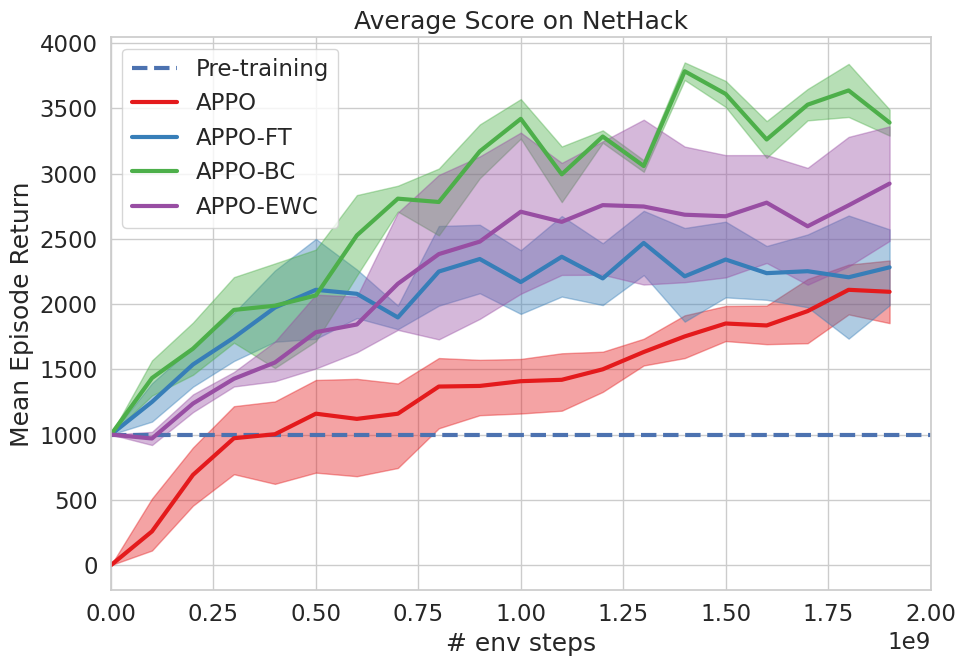

In [81]:
n_rows = 1
n_cols = 1

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 7))

# axes = axes.flatten()
axes = [axes]
legend_handles = []  # Create an empty list to collect legend handles
legend_labels = []   # Create an empty list to collect legend labels

folders = ["None"]

method_translator = {
    "monk-APPO": "APPO",
    "monk-APPO-T": "APPO-FT",
    "monk-APPO-AA-KLAA-T": "APPO-BC",
    "monk-APPO-AA-KLBC-T": "APPO-KLBC",
    "monk-APPO-AA-KS-T": "APPO-KS",
    "monk-APPO-AA-CEAA-T": "APPO-CE",
    "monk-APPO-EWC-T": "APPO-EWC",
}

# TODO: all points should have the same 0-point


# [0 - 2B]
for idx, (ax, level) in enumerate(zip(axes, folders)):
    eval_column = "eval/mean_episode_sokobanfillpit_score" if level == "sokoban" else 'eval/mean_episode_agent_score'
    level_data = data[data["name"].str.contains(level)]
    baseline_val = level_data[(level_data['index'] == 0) & (level_data['group'].str.contains('-T'))][eval_column].mean()
    ax.plot([0, 2_000_000_000], [baseline_val, baseline_val], linestyle='--', label="Pre-training", linewidth=3)
    for e, (method, method_name) in enumerate(zip(methods, method_names)):
        if "BC" in method_name:
            continue
        method_data = level_data[level_data["group"].str.contains(method)].copy()

        method_data = method_data.replace('NaN', pd.NA).dropna()
        method_data = method_data[(method_data['index'] == 0) | (method_data['index'] > 90_000_000)]
        if '-T' in method_name:
            method_data.loc[method_data['index'] == 0, eval_column] = baseline_val

        legend = "full"
        sns.lineplot(data=method_data, x="index", y=eval_column, ax=ax, errorbar=('ci', 90), linewidth=3, legend=legend, label=method_translator[method_name], err_kws={"alpha": .4}, color=color_palette[e])

        ax.set_ylabel("Mean Episode Return")

        ax.set_xlabel("# env steps")
        ax.set_xlim(0, 2_000_000_000)
        # ax.set_xlim(0, 90_000_000)
        # ax.set_ylim(0, 4000)

        level_name = level if level != "None" else "Level start"
        level_name = "Sokoban" if level == "sokoban" else level_name.replace('saves', '')
        ax.set_title(f"Average Score on NetHack")

# axes[0].legend().set_visible(False)
# axes[-1].legend()

plt.tight_layout()

if n_cols > len(folders):
    for ax in axes[len(folders):]:
        ax.axis('off')

# Show or save the plot
plt.show()

In [76]:
import datetime

In [ ]:
end_date = datetime.datetime(2023, 9, 26, 13, 17)

In [14]:
filters2 = {
    "config.exp_tags": ["2023_09_22_eval_full"], 
    "config.exp_kind": "eval",
    "config.exp_point": "monk-APPO",
}

In [15]:
from pathlib import Path

In [16]:
runs = api.runs("gmum/nle", filters=filters2)
print(len(runs))
count = 0 
for run in runs:
    if "APPO_" in run.config["group"]:
        # run.delete()
        count += 1

1718


In [32]:
runs

<Runs gmum/nle>

In [17]:
count

464